# 빅분기Part3-모델링-범주형
Classifier / ~297 ~321

## 전처리- 범주형

In [73]:
### 시간측정, 데이터로드, 종속-독립변수 분리
import time
start_time= time.time()
import pandas as pd
data= pd.read_csv('bigData/mtcars.csv')
# print(data.info(), data.head(), '-----')
# am 인코딩하고 종속변수로 하기
data['am_new']= data['am'].replace('manual',1).replace('auto',0).astype('int64').astype('category')
# data.loc[data['am']=='manual', 'am_new']= 1 도 가능한데, replace 가 역시 생각이 잘 난다.
Y= data['am_new']
X= data.drop(columns=['am', 'am_new', 'Unnamed: 0'])
pd.set_option('display.max_columns',None)
#  X.head()
# print(X.info(), X.head(), '-----')

### null 체크, 이상한거 없애고 데이터타입 변경, 인코딩
# print(X.loc[X.isnull().sum(1)!=0], '-----')
X['cyl'].fillna(X.describe().loc['mean','cyl'], inplace=True)
X['qsec'].fillna(X.describe().loc['mean','qsec'], inplace=True)
# print(X.info(), '-----')
X['gear']= X['gear'].replace('*3','3').replace('*5','5').astype('int64')
# print(X.info()) # 'am' object
# print(pd.get_dummies(X, drop_first=True)) # help(pd.get_dummies)
X= pd.get_dummies(X, drop_first=True)


### 이상치 교체(meanStd or IQR)
## describe -> mean +- 1.5*std, Q3+1.5*IQR 및 Q1-1.5*IQR -> def 컬럼!!별. maxOver minOver. outlierCheck 부터. 다 돌리지마
# print(X.loc[:,X.dtypes=='int64'].nunique(), '-----')  # hp22, vs2, gear3, carb6 종
# print(X.loc[:,X.dtypes=='int64'], '-----') # 정수형 어떻게 생겼나. iloc[:,2].unique() 붙여서 뭐로 이뤄져있는지 볼수도
## 열 조건
# 눈으로 보고 중복처리 안 되게, 돌릴만 한 것만 골라내기.
def outlierCheck(data):
    desc= data.describe()
    max1= desc.loc['max']
    min1= desc.loc['min']
    
    mean= desc.loc['mean']
    std= desc.loc['std']
    minBms= mean-1.5*std # Boundary
    maxBms= mean+1.5*std
    minOverms= min1 < minBms # Boundary 보다 작으면 이상치
    maxOverms= max1 > maxBms
    # print('--minOverMs--', minOverMs)    # print('--maxOverMs--', maxOverMs)
    
    Q1= desc.loc['25%']
    Q3= desc.loc['75%']
    IQR= Q3-Q1
    minBiqr= Q1-1.5*IQR
    maxBiqr= Q3+1.5*IQR
    minOverIQR= min1< minBiqr
    maxOverIQR= max1> maxBiqr
    # print('minOverIQR', minOverIQR, '-----') # print('maxOverIQR', maxOverIQR, '-----')
    
    return minBms, maxBms, minBiqr, maxBiqr

# print(outlierCheck(X))

## 행 조건. outlierCheck 에서 무슨 컬럼을 돌릴지는 정성적으로 정해뒀다.
def outlierReplace(data):
    minBms, maxBms, minBiqr, maxBiqr= outlierCheck(X)
    # outlierCheck 에서 정한 열 조건
    minMScols= ['drat','wt']
    maxMScols= ['disp','drat']
    minIQRcols= ['qsec']
    maxIQRcols= ['cyl', 'hp', 'wt', 'qsec', 'carb']
    #행 조건- 각 열 내의 값이 Boundary Over 인지. data[col]<minBms[col]
    
    for col in minMScols:
#         print(f"BeforeMinMS: {data.loc[ data[col]<minBms[col], col]}, minBms: {minBms[col]:.7}")
        data.loc[ data[col]<minBms[col], col]= minBms[col]
    for col in maxMScols:
#         print(f"BeforeMaxMS: {data.loc[ data[col]>maxBms[col], col]}, maxBms: {maxBms[col]:.7}")
        data.loc[ data[col]>maxBms[col], col]= maxBms[col]
    for col in minIQRcols:
#         print(f"BeforeMinIQR: {data.loc[ data[col]<minBiqr[col], col]}, minBiqr: {minBiqr[col]:.7}")
        data.loc[ data[col]<minBiqr[col], col]= minBiqr[col]
    for col in maxIQRcols:
#         print(f"BeforeMaxIQR: {data.loc[ data[col]>maxBiqr[col], col]}, maxBiqr: {maxBiqr[col]:.7}")
        data.loc[ data[col]>maxBiqr[col], col]= maxBiqr[col]
    
    return data
        
X= outlierReplace(X)
# print(X.info(), X, '-----')

### 파생변수- 스케일링 하기전에
## 무게등급
condition= X['wt']< 3.3
X.loc[condition,'wt_class']= 0
X.loc[~condition,'wt_class']=1
X.drop(columns='wt', inplace= True)
## 1 mile
X['qsec_4']= X['qsec']*4
X.drop(columns='qsec', inplace=True)
# print(X.info(), X, '-----')

### 범주형 명시- 단 xgboost 할거면 하지 말기
# print(X.loc[:,X.dtypes=='int64'])
X['vs']= X['vs'].astype('category')
X['wt_class']= X['wt_class'].astype('int64').astype('category')
# print(X.info(), X, '-----')

### 스케일링- 범위
# from sklearn import preprocessing 
# help(preprocessing) #scaler #MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# help(MinMaxScaler) #example #scaler = MinMaxScaler() #fit_ : fit_transform
# (self, X, y=None, **fit_params)
# 통째가 아니라 한 컬럼만 DF로 넣어야! def scaling(data, scalers):  --- 인자 형식 외워야!
def scaling(scalers, columnDF):
    # 스케일링 해줄 객체
    if scalers=='MinMax':
        scaler= MinMaxScaler()
    elif scalers== 'Standrad':
        scaler== StandardScaler()
    elif scalers== 'Robust':
        scaler== RobustScaler()
    # 객체가 스케일링 해줌
    #scaler.fit_transform(columnDF) # scaler.fit_transform(data)
    scaledCol= pd.DataFrame(scaler.fit_transform(columnDF)) # scaling 후에 DF 로 바꿔야
    return scaledCol

# fit_transform에 Series 넣으면 나오는 에러:  if your data has a single feature 
# or array.reshape(1, -1)
# scaling('MinMax', X[['qsec']])

# print(X.columns[X.dtypes=='float64'])
floatCols= X.columns[X.dtypes=='float64']
for col in floatCols:
    #컬럼으로 받아야! X= scaling('MinMax', X[[col]])
    X[col]= scaling('MinMax', X[[col]])

print(X.info(), X, '-----')
print('\nY:', Y, '-----')

## LabelEncoder 연습
# face= ['happy','sad','soso']
# from sklearn import preprocessing # help(preprocessing)
# from sklearn.preprocessing import LabelEncoder
# encoder= LabelEncoder()
# print(face, encoder.fit_transform(face), '-----'))

print(f"전처리 실행시간 {time.time()-start_time:.7} sec")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   mpg       32 non-null     float64 
 1   cyl       32 non-null     float64 
 2   disp      32 non-null     float64 
 3   hp        32 non-null     float64 
 4   drat      32 non-null     float64 
 5   vs        32 non-null     category
 6   gear      32 non-null     int64   
 7   carb      32 non-null     int64   
 8   wt_class  32 non-null     category
 9   qsec_4    32 non-null     float64 
dtypes: category(2), float64(6), int64(2)
memory usage: 2.4 KB
None          mpg   cyl      disp        hp      drat vs  gear  carb wt_class  \
0   0.451064  0.20  0.257286  0.229023  0.689171  0     4     4        0   
1   0.451064  0.20  0.257286  0.229023  0.689171  0     4     4        0   
2   0.527660  0.00  0.106792  0.161895  0.658000  1     4     1        0   
3   0.468085  0.20  0.540908  0.229023  0.177

## 모델링-범주형
Classifier / p.296

In [76]:
from sklearn.model_selection import train_test_split
# help(train_test_split) #  X_train, X_test, y_train, y_test = train_test_split(\X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

In [83]:
# print(X_train.info(), X_train.head(2), '---')
# print(X_test.info(), X_test.head(2), '---')
# print(y_train.head(2), '---')
# print(y_test.head(2), '---')

### 모델-DecisionTreeClassifier
의사결정나무 분류 모델 / p.298
- 분류평가 방법: roc_auc_score, 정확도 accuracy_score, 정밀도 precision_score, 재현율 recall_score
- [정확도 정밀도 민감도 재현율](https://www.google.com/search?q=%EC%A0%95%ED%99%95%EB%8F%84+%EC%A0%95%EB%B0%80%EB%8F%84+%EB%AF%BC%EA%B0%90%EB%8F%84+%EC%9E%AC%ED%98%84%EC%9C%A8&newwindow=1&sxsrf=ALiCzsaaB4XgFJae_3wEdTNY05x2Fpll5A:1655458624640&source=lnms&tbm=isch&sa=X&ved=2ahUKEwjr-4v6l7T4AhVIB6YKHQkXCaMQ_AUoAXoECAEQAw&biw=1292&bih=665&dpr=1)

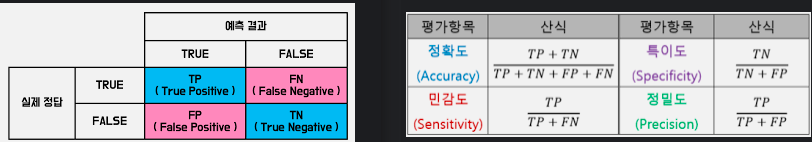

In [94]:
# import sklearn # help(sklearn) # package/ tree
# from sklearn import tree # help(tree) # class/ DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
# help(DecisionTreeClassifier) # example/ clf = DecisionTreeClassifier(random_state=0)

## 학습자. 70% 학습. 70% 예측. 그 외 30% 예측
model= DecisionTreeClassifier()
model.fit(X_train, y_train)
y_train_predict= model.predict(X_train)
y_test_predict= model.predict(X_test)

## 모델 평가 [70%, 그 외 30%] - [roc_auc_score, accuracy_score, precision_score, recall_score]
# import sklearn # help(sklearn) # package/ metrics
# from sklearn import metrics # help(metrics) # _score 검색. roc_auc_score, accuracy_score
# , 간간이 보이는 precision으로 유추해야 precision_score, 한참 내려가면 recall_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
# help(roc_auc_score) # examples/ roc_auc_score(y, clf.predict_proba(X)[:, 1])

print('test roc_auc: ', roc_auc_score(y_test, y_test_predict))
print('test 정확도accuracy (실제==예측)/all: ', accuracy_score(y_test, y_test_predict))
print('test 정밀도precision (실제T==예측T)/예측T: ', precision_score(y_test, y_test_predict))
print('test 재현율(민감도)recall (실제T==예측T)/실제T: ', recall_score(y_test, y_test_predict))

test roc_auc:  0.7857142857142857
test 정확도accuracy (실제==예측)/all:  0.7
test 정밀도precision (실제T==예측T)/예측T:  0.5
test 재현율(민감도)recall (실제T==예측T)/실제T:  1.0


### 모델- 랜덤포레스트 분류
RandomForestClassifier / p.300

In [127]:
# import sklearn # help(sklearn) #ensemble
# from sklearn import ensemble # help(ensemble) #randomforest. RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
# help(RandomForestClassifier) #clf = RandomForestClassifier(max_depth=2, random_state=0) #clf.fit(X, y)

## 학습자. 70% 학습. 70% 예측. 나머지 30% 예측
model= RandomForestClassifier()
model.fit(X_train, y_train)
y_train_predict= model.predict(X_train)
y_test_predict= model.predict(X_test)

## 모델 평가. 나머지 30% [roc_auc_score, accuracy_score, precision_score, recall_score]
# from sklearn import metrics # help(metrics) #_score 검색. 2,3번째, ctrl F Enter 주욱 누르고 있으면 가끔.
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

print('train roc_auc: ', roc_auc_score(y_train, y_train_predict)) # 1.0 완벽한 과적합
print('test roc_auc: ', roc_auc_score(y_test, y_test_predict))
print('test accuracy_score: ', accuracy_score(y_test, y_test_predict))
print('test precision_score: ', precision_score(y_test, y_test_predict))
print('test recall_score: ', recall_score(y_test, y_test_predict))

train roc_auc:  1.0
test roc_auc:  0.8571428571428572
test accuracy_score:  0.8
test precision_score:  0.6
test recall_score:  1.0


##### 뭔가 잘못 되었다. 모델 관계없이 score 가 계속 똑같이 나온다
전처리 부분에서 'am' 걸러낼 때 뭔가 실수했나??
- 다시 실행하니 random_state 바뀌어서 다른 게 나오긴 한다. 
- roc_auc 0.69 ~ 0.85714

> 계속 똑같이 나오는 이유 추정: 같은 데이터 셋이라, accuracy, precision, recall 은 같게 나오나??

### 모델- 로지스틱 회귀
LogisticRegression / p.301

In [132]:
from sklearn.linear_model import LogisticRegression
# 분류 모델인데 이름이.. '선형회귀' 라서 ㅇㅇ
# help(LogisticRegression) # clf = LogisticRegression(random_state=0).fit(X, y) #clf.predict(X[:2, :])
# import sklearn # help(sklearn) #linear_model
# from sklearn import linear_model # help(linear_model) # classes/ LogisticRegression

## 학습자 70% 학습. 70% 예측, 나머지 30% 예측
model= LogisticRegression().fit(X_train, y_train)
# y_train_predict= model.predict(X_train) # 잘 학습했을거라고 가정하고 생략?!
y_test_predict= model.predict(X_test)

## 모델 평가. 나머지 30%. roc_auc_score
from sklearn.metrics import roc_auc_score
print('test roc_auc: ', roc_auc_score(y_test, y_test_predict))

test roc_auc:  0.9285714285714286


### 모델- XGBClassifier
eXtreme Gradient Boosting / p.302
- 값 예측: model.predict(실제y_test, 예측y_test_predict)
- 확률예측:model.predict_proba(x_test) 

In [153]:
# !pip install xgboost
from xgboost import XGBClassifier
# import xgboost # help(xgboost) # class/ XGBClassifier

# xgboost 에 넣는 데이터는 category 쓰기 어렵다.
# print(X_train.info())
X_train['vs']= X_train['vs'].astype('int64')
X_train['wt_class']= X_train['wt_class'].astype('int64')
y_train= y_train.astype('int64')

X_test['vs']= X_test['vs'].astype('int64')
X_test['wt_class']= X_test['wt_class'].astype('int64')
y_test= y_test.astype('int64')

# 70% 학습
model= XGBClassifier().fit(X_train, y_train)

## 확률 예측. 나머지 30%
y_test_proba= model.predict_proba(X_test)
print('확률예측: ', y_test_proba)
print(y_test_proba.shape, '1열: 값이 0일 확률, 2열: 값이 1일 확률')

# ## 값 예측. 잘 했다 가정하고 나머지 30%
y_test_predict= model.predict(X_test)
print('값 예측: ', y_test_predict)
print(y_test_predict.shape)

from sklearn.metrics import roc_auc_score
print('test roc_auc: ', roc_auc_score(y_test, y_test_predict))

확률예측:  [[0.48592138 0.5140786 ]
 [0.33667523 0.6633248 ]
 [0.96512055 0.03487942]
 [0.1298446  0.8701554 ]
 [0.31327152 0.6867285 ]
 [0.88660794 0.11339206]
 [0.96512055 0.03487942]
 [0.6066751  0.3933249 ]
 [0.952859   0.04714101]
 [0.1038906  0.8961094 ]]
(10, 2) 1열: 값이 0일 확률, 2열: 값이 1일 확률
값 예측:  [1 1 0 1 1 0 0 0 0 1]
(10,)
test roc_auc:  0.619047619047619


C:\Users\optim\AppData\Local\Temp/ipykernel_11612/2775519470.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['vs']= X_train['vs'].astype('int64')
C:\Users\optim\AppData\Local\Temp/ipykernel_11612/2775519470.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['wt_class']= X_train['wt_class'].astype('int64')
C:\Users\optim\AppData\Local\Temp/ipykernel_11612/2775519470.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

### 모델- SVC, 배깅, KNN, 다층퍼센트론
- from sklearn.svm import SVC
- from sklearn.ensemble imiport BaggingClassifier
- from sklearn.neighbors import KNeighborsClassifier
- from sklearn.neural_network import MLPClassifier
> from sklearn.metrics import roc_auc_score

[svc predict_proba is not available when probability=False](https://beausty23.tistory.com/146)
- model 객체 생성시 svm = SVC(probability=True)

In [164]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

def modelingClassifier(models):
    if models=='svc':
        model= SVC(probability=True) #서포트 벡터 분류. Support Vector Classification
    elif models=='bagging':
        model= BaggingClassifier()
    elif models=='knn':
        model= KNeighborsClassifier()
    elif models=='mlp':
        model= MLPClassifier()
    model.fit(X_train, y_train)
    return model

def predictTestClassifier(model, how):
    if how=='value':
        y_test_predict= model.predict(X_test)
        print('test value roc_auc: ', roc_auc_score(y_test, y_test_predict))
    elif how=='proba':
        y_test_proba= model.predict_proba(X_test)
        print('test proba: ', y_test_proba)

# model= modelingClassifier('svc')
model= modelingClassifier('mlp')
# predictTestClassifier(model, 'value')
predictTestClassifier(model, 'proba')

test proba:  [[0.58624081 0.41375919]
 [0.42782933 0.57217067]
 [0.98199308 0.01800692]
 [0.23535138 0.76464862]
 [0.52980726 0.47019274]
 [0.97334678 0.02665322]
 [0.96454914 0.03545086]
 [0.19058007 0.80941993]
 [0.954478   0.045522  ]
 [0.08978401 0.91021599]]


e:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [165]:
!ls

bigData
data
j.bat
鍮낅텇湲� �빋=�떎湲곕떒�떟_encoding_utf.pdf
鍮낅텇湲캰art2.ipynb
鍮낅텇湲캰art2.py
鍮낅텇湲캰art3-�뜲�씠�꽣 紐⑥뼇援ъ“�듅吏�.ipynb
鍮낅텇湲캰art3-�뜲�씠�꽣-紐⑥뼇援ъ“�듅吏�.py
鍮낅텇湲캰art3-紐⑤뜽留�-踰붿＜�삎.ipynb
鍮낅텇湲캰art3-紐⑤뜽留�-踰붿＜�삎.py
鍮낅텇湲캰art3-紐⑤뜽留�-�뿰�냽�삎.ipynb
鍮낅텇湲캰art3-紐⑤뜽留�-�뿰�냽�삎.py
鍮낅텇湲캰art3-�쟾泥섎━-�뒪耳��씪留�_�씤肄붾뵫.ipynb
鍮낅텇湲캰art3-�쟾泥섎━-�뒪耳��씪留�_�씤肄붾뵫.py
鍮낅텇湲캰art3-�쟾泥섎━-�씠�긽移�.ipynb
鍮낅텇湲캰art3-�쟾泥섎━-�씠�긽移�.py


# 제출방법- 작업 1유형

In [168]:
# 값 하나만!! 나머지는 다 주석처리
print(roc_auc_score(y_test, y_test_predict))

0.619047619047619


# 제출방법- 작업 2유형
p.309

In [170]:
# 파생변수 만졌으면 컬럼명도 rename 해야 한다고 함

# 제출할 대상이 DataFrame 인지 아닌지 확인
print(type(y_test_proba))
# 아니면 DataFrame 으로 변경후 to_csv
# 이 때, 반드시!! 인덱스 번호는 False 로 둔다. 
pd.DataFrame(y_test_proba).to_csv('data/job2_y_test_proba.csv', index=False)

<class 'numpy.ndarray'>


In [183]:
# help(dir)
# from sklearn import tree #help(tree)
# dir(DecisionTreeClassifier) # 정보가 영 없다.
# help(RandomForestClassifier) # 3번째 줄에 n_estimators 있다